In [1]:
import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

In [ ]:
# !ls

### **ARIMA**

In [3]:
from statsmodels.tsa.arima_model import ARIMA


def arima_test(close, use_rows=None):

  size = int(len(close) * 0.66)
  train, test = close[0:size].values, close[size:len(close)]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 1))
      model_fit = model.fit(trend='c', disp=0)
      output = model_fit.forecast()
      # print(output)
      # break
      yhat = output[0]
      predictions.append(yhat)
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, leverage=1, show_detail=False, show_plot=False, return_pr=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  fee = 0.0006
  profits = list()
  win_cnt = 0
  for i in range(len(test)):

    long_ep = (predictions[i] - err_ranges[i]) * (1 / (tp + 1))
    short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    # print((low[i]))
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      if max(l_liquidation, 0) == 0:
        l_profit = 0
      else:
        profit = test[i] / long_ep - fee
        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      profits.append(l_profit)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    elif high[i] > short_ep:

      liquidation = short_ep / high[i]  - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      if max(l_liquidation, 0) == 0:
        l_profit = 0
      else:
        profit = short_ep / test[i] - fee
        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)

        if profit >= 1:
          win_cnt += 1

      profits.append(l_profit)

      if show_detail:
        print(test[i], predictions[i], short_ep)
    
    else:
      profits.append(1.0)

  win_ratio = win_cnt / sum(np.array(profits) != 1.0)
  frequency = sum(np.array(profits) != 1.0) / len(test)
  accum_profit = np.array(profits).cumprod()

  # print(win_ratio)

  if show_plot:
    plt.plot(profits)
    plt.title('Win Ratio : %.2f %% Frequency : %.2f %%' % (win_ratio * 100, frequency * 100), color='white')
    plt.show()

    # print()
    plt.plot(accum_profit)
    plt.title('Accum_profit : %.2f' % accum_profit[-1], color='white')
    plt.show()

  return win_ratio, frequency, accum_profit[-1], profits


# get_back_result(tp=0.04, leverage=1, show_plot=True)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Load OHLCV**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/old/' % interval
# date_path = './candlestick_concated/%s/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-02-11 XMRUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 BTCUSDT.xlsx']


### **Back-Test Analyze**

In [3]:
# pickle.format_version
# print(pd.show_versions())
!pip install pandas==0.25.3

In [ ]:
import pickle 

with open('./arima_result/old/arima_candi_profit_result_%s.pickle' % interval, 'rb') as f:
  load_candi_pr_dict = pickle.load(f)

# result_dict = dict()

for file in file_list:

  # file = '2021-02-07 ETH.xlsx'
  print(file)
  if not file.endswith('xlsx'):
    continue

  ohlcv = pd.read_excel(date_path + file, index_col=0)
  # print(len(ohlcv))
  temp_dict =  load_candi_pr_dict[file]
  print(temp_dict['ohlcv'])
  # temp_dict['ohlcv'] = ohlcv
  # break

# print(result_dict[file]['ohlcv'])

# with open('./arima_result/old/arima_candi_profit_result_%s.pickle' % interval, 'wb') as f:
#   pickle.dump(load_candi_pr_dict, f)

#### **Save predictions & err_ranges**

In [ ]:
import pickle

result_dict = dict()

for file in file_list:

  # file = '2021-02-07 ETH.xlsx'
  print(file)
  if not file.endswith('xlsx'):
    continue

  ohlcv = pd.read_excel(date_path + file, index_col=0)
  print(len(ohlcv))
  # print(ohlcv.head())

  temp_dict =  dict()
  temp_dict['ohlcv'] = ohlcv
  # print(temp_dict)
  # break

  close = ohlcv.iloc[:, [3]]
  predictions, err_ranges = arima_test(close, 3000)

  temp_dict['predictions'] = predictions
  temp_dict['err_ranges'] = err_ranges
  result_dict[file] = temp_dict

  # break

#         save dict       #
with open('./arima_result/arima_test_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(result_dict, f)

### **Load & Individually Plotting & Add Backtest_Result**

In [8]:
import pickle
with open('./arima_result/arima_test_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)

keys = list(load_dict.keys())
# print(keys)
print(list(load_dict[keys[5]].keys()))
print(load_dict[keys[0]]['ohlcv'][-5:])

['ohlcv', 'predictions', 'err_ranges']
[[2.9563000e+00 2.9839000e+00 2.9415000e+00 2.9544000e+00 5.3616460e+05]
 [2.9542000e+00 3.0256000e+00 2.9460000e+00 2.9685000e+00 9.0717680e+05]
 [2.9685000e+00 3.0465000e+00 2.9685000e+00 3.0224000e+00 8.4765610e+05]
 [3.0224000e+00 3.0515000e+00 2.9585000e+00 2.9896000e+00 1.3443617e+06]
 [2.9905000e+00 3.0584000e+00 2.9824000e+00 3.0310000e+00 6.4790710e+05]]


2021-02-11 BTCUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

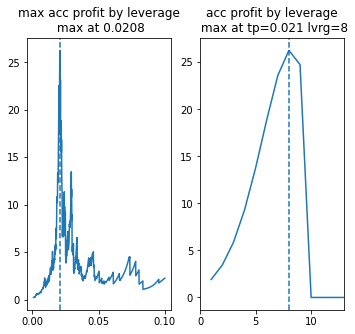

2021-02-11 ETHUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

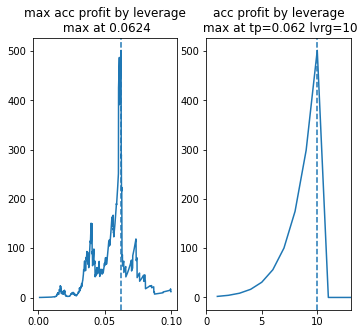

2021-02-11 BCHUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

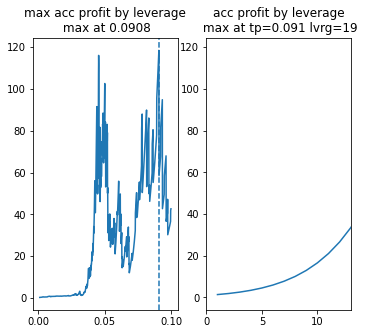

2021-02-11 XRPUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

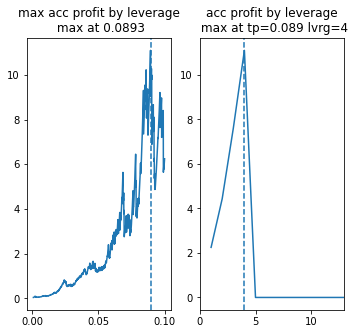

2021-02-11 EOSUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

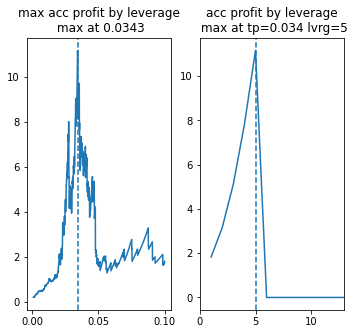

2021-02-11 LTCUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

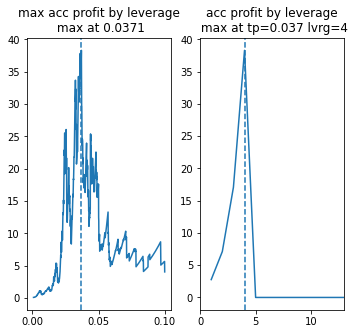

2021-02-11 ETCUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

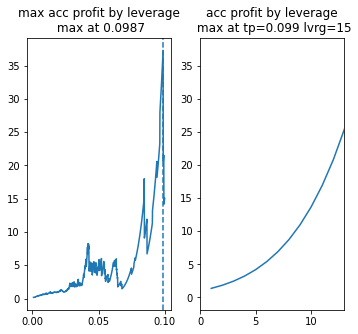

2021-02-11 LINKUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

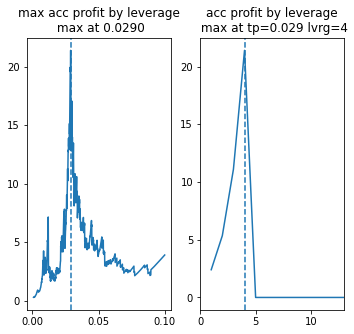

2021-02-11 XLMUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

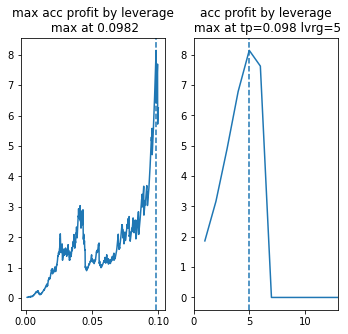

2021-02-11 ADAUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

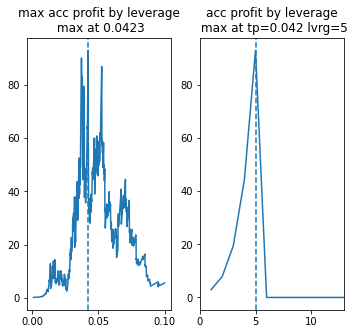

2021-02-11 XMRUSDT.xlsx
 0.10%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

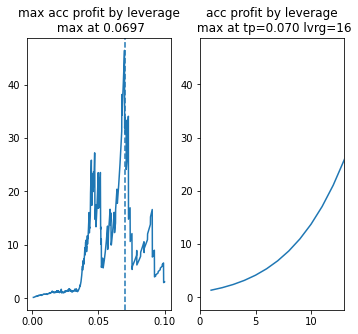

In [ ]:
import pickle

with open('./arima_result/arima_test_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)

tp_list = np.arange(0.001, 0.1, 0.0001)
leverage_list = np.arange(1, 30, 1)
# tp_list = [selected_tp]

for key in load_dict.keys():

  print(key)

  #       tp analysis     #
  ohlcv = load_dict[key]['ohlcv']
  predictions = load_dict[key]['predictions']
  err_ranges = load_dict[key]['err_ranges']

  wr_list, fr_list, ap_list = list(), list(), list()
  max_ap_list = list()  

  progress_cnt = 0
  # selected_ap_list = list()
  for tp in tp_list:

    progress_cnt += 1
    print('\r %.2f%%' % (progress_cnt / len(tp_list) * 100), end='')

    #     leverage analysis     #
    temp_ap_list = list()
    for leverage in leverage_list:

      try:
        result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage)
        temp_ap_list.append(result[2])

      if round(leverage) == 1:

        wr_list.append(result[0])
        fr_list.append(result[1])
        ap_list.append(result[2])

      except Exception as e:
        print(e)
        break

    max_ap_list.append(max(temp_ap_list))

  # print(wr_list)
  # break

  #     stack dict    #
  temp_dict = load_dict[key]
  temp_dict['tp_list'] = tp_list[:len(ap_list)]
  temp_dict['wr_list'] = wr_list
  temp_dict['fr_list'] = fr_list
  temp_dict['ap_list'] = ap_list
  temp_dict['max_ap_list'] = max_ap_list


  #     individual plot   #
  plt.figure(figsize=(15, 5))

  plt.subplot(151)
  plt.plot(tp_list[:len(ap_list)], wr_list)
  plt.title('win ratio')

  plt.subplot(152)
  plt.plot(tp_list[:len(ap_list)], fr_list)
  plt.title('frequency')

  plt.subplot(153)
  plt.plot(tp_list[:len(ap_list)], ap_list)
  argmax = np.argmax(ap_list)
  plt.axvline(tp_list[:len(ap_list)][argmax], linestyle='--')
  plt.title('acc profit, max at %.4f' % (tp_list[:len(ap_list)][argmax]))  

  plt.subplot(154)
  plt.plot(tp_list[:len(max_ap_list)], max_ap_list)
  argmax = np.argmax(max_ap_list)
  plt.axvline(tp_list[:len(max_ap_list)][argmax], linestyle='--')
  plt.title('max acc profit by leverage\n max at %.4f' % (tp_list[:len(max_ap_list)][argmax])) 

  # plt.show()
  selected_tp = tp_list[:len(max_ap_list)][argmax]
  #     leverage analysis     #
  selected_ap_list = list()
  for leverage in leverage_list:

    try:
      result = get_back_result(ohlcv, predictions, err_ranges, tp=selected_tp, leverage=leverage)
      selected_ap_list.append(result[2])

    except Exception as e:
      print(e)
      break
  
  #     stack dict    #
  temp_dict['leverage_list'] = leverage_list[:len(selected_ap_list)]
  temp_dict['leverage_ap_list'] = selected_ap_list
  
  plt.subplot(155)
  plt.plot(leverage_list[:len(selected_ap_list)], selected_ap_list)
  argmax = np.argmax(selected_ap_list)
  plt.title('acc profit by leverage\n max at tp=%.3f lvrg=%.0f' % (selected_tp, leverage_list[:len(selected_ap_list)][argmax]))  
  plt.axvline(leverage_list[:len(selected_ap_list)][argmax], linestyle='--')
  plt.xlim(0, 13)

  plt.show()


#         save dict 2       #
with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(load_dict, f)
  

### **Sum Plot**

In [ ]:
with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  profit_result_dict = pickle.load(f)

with open('./arima_result/backup/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  backup_dict = pickle.load(f)

keys2 = list(backup_dict.keys())
for key in keys2:
  
  profit_result_dict[key]['tp_list'] = backup_dict[key]['tp_list']
  profit_result_dict[key]['wr_list'] = backup_dict[key]['wr_list']
  profit_result_dict[key]['fr_list'] = backup_dict[key]['fr_list']
  profit_result_dict[key]['ap_list'] = backup_dict[key]['ap_list']

In [ ]:
list(profit_result_dict['2021-02-11 ADAUSDT.xlsx'].keys())

['ohlcv',
 'predictions',
 'err_ranges',
 'max_ap_list',
 'leverage_list',
 'leverage_ap_list',
 'tp_list',
 'wr_list',
 'fr_list',
 'ap_list']

In [ ]:
#         save dict 2       #
with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(profit_result_dict, f)
  

dict_keys(['2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx'])


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

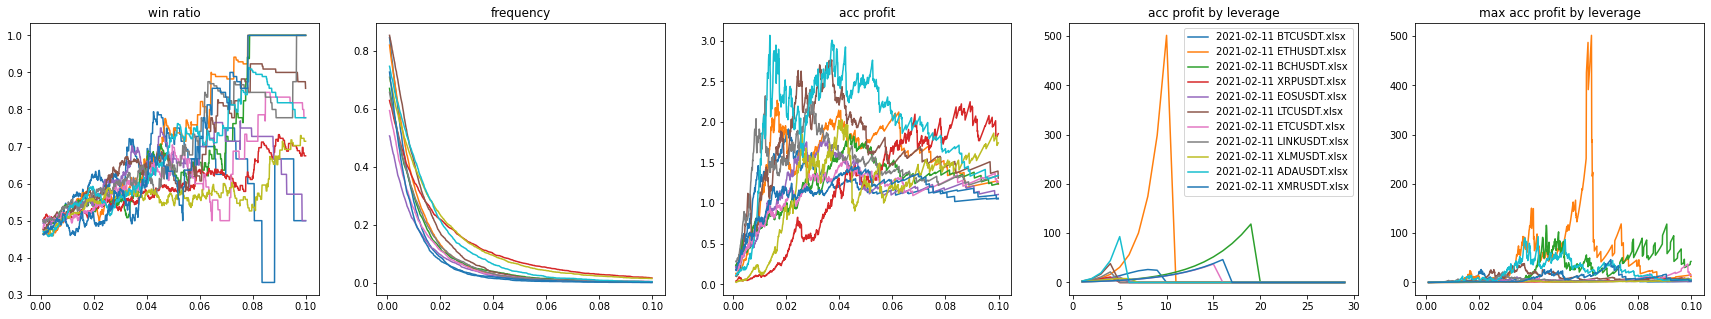

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
# print(type(result_dict))

with open('./arima_result/old/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  profit_result_dict = pickle.load(f)

keys = profit_result_dict.keys()
print(keys)
# keys = ['2021-02-07 ETH.xlsx']
# break


plt.figure(figsize=(30, 5))

plt.subplot(151)
plt.title('win ratio')  
for key in keys:  
  plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['wr_list'])


plt.subplot(152)
plt.title('frequency')  
for key in keys:  
  plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['fr_list'])

  
plt.subplot(153)
plt.title('acc profit')  
for key in keys:  
  plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])

plt.subplot(155)
plt.title('max acc profit by leverage')  
for key in keys:  
  plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
  
plt.subplot(154)
plt.title('acc profit by leverage')  
for key in keys:  
  plt.plot(profit_result_dict[key]['leverage_list'], profit_result_dict[key]['leverage_ap_list'], label=key)
  # print(result_dict[key]['leverage_ap_list'])
plt.legend()

plt.show()


### **Extract Candidate pairs**

In [6]:
pairs = list(keys)
result_df = pd.DataFrame(index=pairs)
profit = list()
max_lv_profit = list()
for key in keys:  
  # print(np.max(profit_result_dict[key]['ap_list']))
  profit.append(np.max(profit_result_dict[key]['ap_list']))
  # print(np.max(profit_result_dict[key]['leverage_ap_list']))
  max_lv_profit.append(np.max(profit_result_dict[key]['leverage_ap_list']))

# result_df['index'] = pairs
result_df['profit']= profit
result_df['max_lv_profit']= max_lv_profit
# print(result_df)

#     sort by values    #
print(result_df.sort_values(by='profit', ascending=False))
print(result_df.sort_values(by=['max_lv_profit'], ascending=False))

#     extract candidates    #
candis = result_df.sort_values(by=['max_lv_profit'], ascending=False).index[:5]
print(candis)

                            profit  max_lv_profit
2021-02-11 ADAUSDT.xlsx   3.066570      93.044720
2021-02-11 LTCUSDT.xlsx   2.764541      38.302187
2021-02-11 LINKUSDT.xlsx  2.399806      21.401990
2021-02-11 ETHUSDT.xlsx   2.267292     501.546092
2021-02-11 XRPUSDT.xlsx   2.249367      11.099561
2021-02-11 XLMUSDT.xlsx   2.028710       8.140460
2021-02-11 BTCUSDT.xlsx   1.913814      26.266777
2021-02-11 BCHUSDT.xlsx   1.846527     118.506533
2021-02-11 EOSUSDT.xlsx   1.826660      11.163120
2021-02-11 ETCUSDT.xlsx   1.553362      37.303758
2021-02-11 XMRUSDT.xlsx   1.455017      46.400591
                            profit  max_lv_profit
2021-02-11 ETHUSDT.xlsx   2.267292     501.546092
2021-02-11 BCHUSDT.xlsx   1.846527     118.506533
2021-02-11 ADAUSDT.xlsx   3.066570      93.044720
2021-02-11 XMRUSDT.xlsx   1.455017      46.400591
2021-02-11 LTCUSDT.xlsx   2.764541      38.302187
2021-02-11 ETCUSDT.xlsx   1.553362      37.303758
2021-02-11 BTCUSDT.xlsx   1.913814      26.266777


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### **Optimization**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

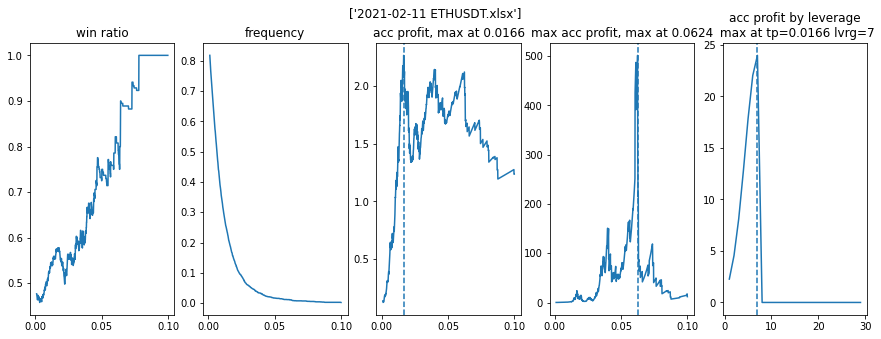

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

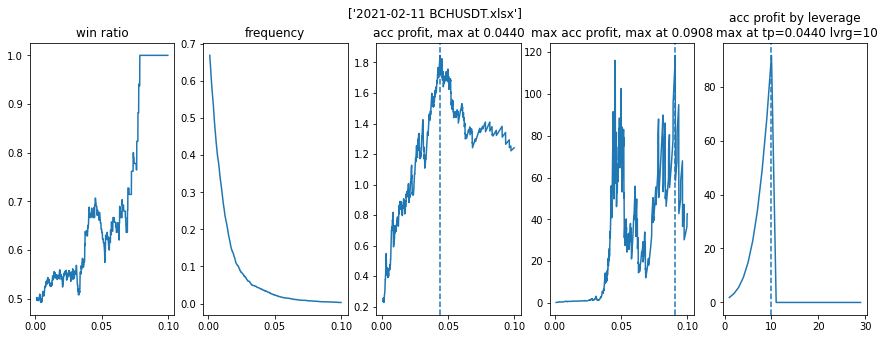

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

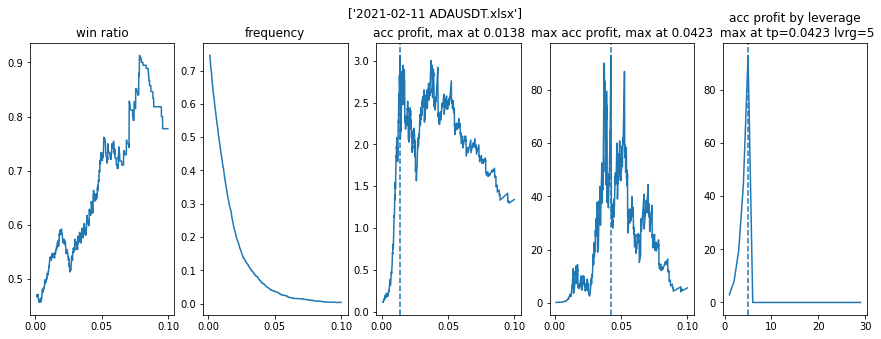

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

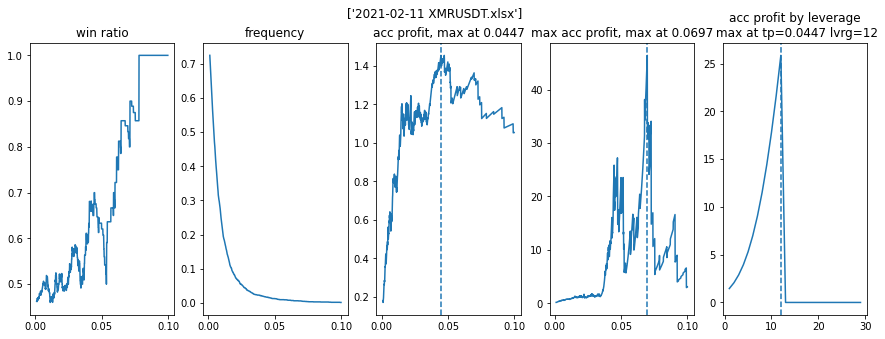

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

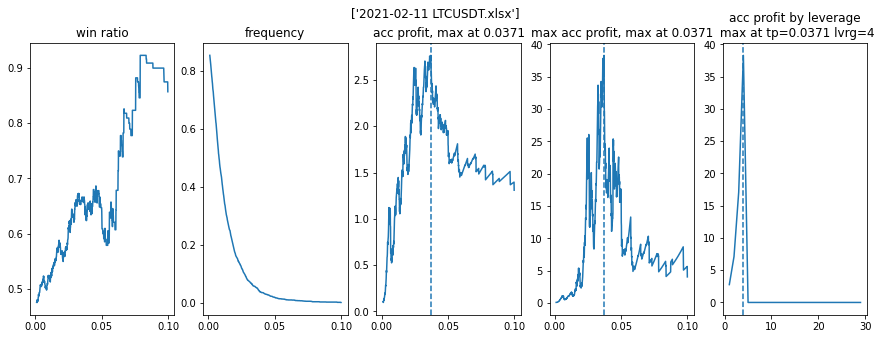

In [9]:
for i in range(len(candis)):

  keys = [candis[i]]

  plt.figure(figsize=(15, 5))
  plt.suptitle(keys)

  plt.subplot(151)
  plt.title('win ratio')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['wr_list'])


  plt.subplot(152)
  plt.title('frequency')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['fr_list'])

    
  plt.subplot(153)
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
    argmax = np.argmax(profit_result_dict[key]['ap_list'])
    peak_tp = profit_result_dict[key]['tp_list'][argmax]
    plt.axvline(peak_tp, linestyle='--')
    plt.title('acc profit, max at %.4f' % (peak_tp))  

  plt.subplot(154)
  plt.title('max acc profit by leverage')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
    argmax = np.argmax(profit_result_dict[key]['max_ap_list'])
    max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
    plt.axvline(max_peak_tp, linestyle='--')
    plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  plt.subplot(155)
  # selected_tp_list = [1, 1, 1, 1, 1]
  selected_tp_list = np.zeros(5)
  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    #     leverage analysis     #
    ohlcv = profit_result_dict[key]['ohlcv']
    predictions = profit_result_dict[key]['predictions']
    err_ranges = profit_result_dict[key]['err_ranges']
    tp = max_peak_tp if selected_tp_list[i] else peak_tp
    leverage_list = profit_result_dict[key]['leverage_list']
    temp_ap_list = list()
    profit_list = list()

    for leverage in leverage_list:

      try:
        result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage)
        temp_ap_list.append(result[2])

        if round(leverage) == 1:
          profit_list = result[3]

      except Exception as e:
        print(e)
        break

    
    profit_result_dict[key]['pr_list'] = profit_list

    plt.plot(profit_result_dict[key]['leverage_list'],temp_ap_list, label=key)
    argmax = np.argmax(temp_ap_list)
    plt.title('acc profit by leverage\n max at tp=%.4f lvrg=%.0f' % (tp, profit_result_dict[key]['leverage_list'][argmax]))  
    plt.axvline(profit_result_dict[key]['leverage_list'][argmax], linestyle='--')
    # plt.xlim(0, 13)
  
  

  plt.show()


#         save dict 2       #
with open('./arima_result/arima_candi_profit_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(profit_result_dict, f)
  

In [17]:
with open('./arima_result/old/arima_candi_profit_result_%s.pickle' % interval, 'rb') as f:
  load_candi_pr_dict = pickle.load(f)

# plt.plot(load_candi_pr_dict['2021-02-11 ADAUSDT.xlsx']['ohlcv'])
print(len(load_candi_pr_dict['2021-02-11 ADAUSDT.xlsx']['predictions']))
print(len(load_candi_pr_dict['2021-02-11 ADAUSDT.xlsx']['pr_list']))

4913
4913
